### Semi-parametric psychophysical model tutorial

This tutorial will demonstrate how to fit the semiparametric psychophysical models described in [Keeley et al., 2023](https://arxiv.org/abs/2302.01187). 

The semi-parametric model uses a conventional parametric form for the monotonic intensity or stimulus dimension (e.g. contrast, amplitude sound pressure level, etc), of the form $f(x) = k(x + c)$ for a stimulus intensity level $x$, intercept or threshold $c$ and slope $k$. It then puts flexible Gaussian Process (GP) priors on the both the slope and intercept parameters as a function of other stimulus dimensions. Informally, it can be thought of as a flexible nonlinear generalization of the model in QUEST+ ([Watson, 2017](https://jov.arvojournals.org/article.aspx?articleid=2611972)) in that it uses the same model for the intensity dimension but replaces the fixed parametric model for the context dimension that QUEST+ uses, with a GP. AEPsych's `BernoulliMCMutualInformation` acquisition function is equivalent to the infomax sampling policy in QUEST+ (also known as BALD in the ML literature). 

The SemiP paper provides both the "full" semi-parametric model (with independent GP posteriors estimated for the slope and intercept), and a multivariate normal-approximate semiparametric model, which derives an approximate single-MVN posterior to the SemiP model. The full SemiP model tends to be more accurate but slower and less compatible with state of the art lookahead sampling policies that rely on an MVN posterior. 

This notebook will demonstrate fitting of both models on the novel discrimination and detection test functions developed in [Owen et al., 2021](https://arxiv.org/abs/2104.09549). These test functions include a nontrivial interaction between context and intensity dimensions devised to be challenging for traditional methods that only assume additive threshold shifts by context. 

In [1]:
# imports and seeds
import matplotlib.pyplot as plt
import numpy as np
import torch
from aepsych.benchmark.test_functions import novel_detection_testfun, novel_discrimination_testfun
from aepsych.utils import dim_grid, make_scaled_sobol
from scipy.stats import norm
from torch.distributions import Bernoulli, Normal


np.random.seed(1)
torch.manual_seed(1)

Below we import the SemiP specific packages. Note that we are importing three link functions here, ```FloorGumbelObjective, FloorLogitObjective, FloorProbitObjective```. In this tutorial we will only use the ```FloorProbitObjective``` to match how we generate synthetic data. From a theoretical perspective, the link function is the CDF of the noise in the perceptual system (i.e. Probit link implies Gaussian Noise, Logit link implies Logistic noise, and Gumbel link implies Weibull noise) and empirically different links may perform better on different datasets, so we recommend that you select the appropriate link for your application based on cross-validated performance or a priori theoretical motivation. 

In [2]:
### SemiP imports

from aepsych.likelihoods import BernoulliObjectiveLikelihood
from aepsych.acquisition.objective import (
    FloorGumbelObjective,
    FloorLogitObjective,
    FloorProbitObjective,
)
from aepsych.likelihoods.semi_p import LinearBernoulliLikelihood
from aepsych.models import HadamardSemiPModel, SemiParametricGPModel

#### Test function
Here we will import the novel 2D detection test function, which provides detection probabilities ranging from 0 to 1 in a two dimensional space. The slope and intercept of the parameterized sigmoidal function vary with a fourth-order polynomial as a function of the context dimension, which makes this a challenging problem for fully parametric models that tend to not include such higher-order terms. 

The lower and upper bound ```lb``` and ```ub``` are needed to specify the boundaries of the function, and should be vectors of length equal to the dimensionality of the dataset you are looking to fit. The function is plotted below.

Text(0.5, 1.0, '2D detection test function')

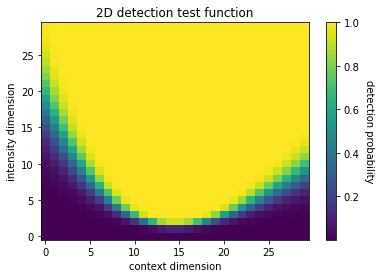

In [3]:
# Detection test function
lb = [-1, -1] 
ub = [1, 1]

xgrid = dim_grid(lower=lb, upper=ub, dim=2)

fgrid = novel_detection_testfun(xgrid)

plt.imshow(norm.cdf(fgrid).reshape(30, 30).T, aspect="auto", origin="lower")
cbar = plt.colorbar()
plt.xlabel("context dimension")
plt.ylabel("intensity dimension")

cbar.set_label("detection probability", rotation=270, labelpad=15)
plt.title("2D detection test function")

In [4]:
# now generate some data from the Bernoulli distribution defined over a set of training locations

xtrain = make_scaled_sobol(lb=lb, ub=ub, size=100) # using random sobol sampling here for data generation
ftrain = novel_detection_testfun(xtrain)
ytrain = Bernoulli(torch.Tensor(norm.cdf(ftrain))).sample()


#### Fitting the model
Here we are fitting both the SemiParametric ```SemiParametricGPMOdel``` as well as the MVN-approximate SemiP model ```HadamardSemiPModel``` using the synthetic data generated in the cell above. We show tuning estimation for each model. Note here the argument ```stim_dim``` in the function call. This is needed to specify which dimension in your dataset should be the monotonically increasing (sigmoidal) dimension. This could be, for example, volume in an auditory task, or contrast in a visual task. Identifying which dimension is monotonic is crucial to see good SemiP performance. Here, the second dimension is the monotonic dimensional in our 2D test function.

In [5]:
### fit SemiP models
semip_model = SemiParametricGPModel(lb=lb, ub=ub, dim=2, stim_dim=1, 
                                    likelihood=LinearBernoulliLikelihood(objective=FloorProbitObjective(floor=0)))
approx_model = HadamardSemiPModel(lb=lb, ub=ub, dim=2, stim_dim=1,
                                  likelihood=BernoulliObjectiveLikelihood(objective=FloorProbitObjective(floor=0)))

semip_model.fit(xtrain, ytrain)
approx_model.fit(xtrain, ytrain)

2023-05-24 13:03:39,345 [INFO   ] Starting fit...
2023-05-24 13:03:41,331 [INFO   ] Fit done, time=1.984814167022705
2023-05-24 13:03:41,335 [INFO   ] Starting fit...
2023-05-24 13:03:41,884 [INFO   ] Fit done, time=0.5479261875152588


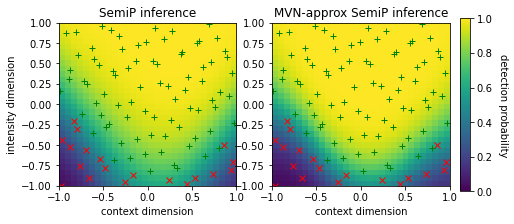

In [6]:
#make predictions at locations on a 2D grid and plot
semiP_pred_mu, _ = semip_model.predict(torch.Tensor(xgrid), probability_space=True)
MVN_pred_mu, _ = approx_model.predict(torch.Tensor(xgrid), probability_space=True)


fig, axs = plt.subplots(1, 2, figsize=(7, 3))
axs[0].set_ylabel("intensity dimension")
im1 = axs[0].imshow(semiP_pred_mu.reshape(30, 30).T, aspect="auto", origin="lower", vmin=0, vmax=1,
                    extent=[lb[0], ub[0], lb[1], ub[1]])
axs[0].set_title('SemiP inference')
axs[0].set_xlabel("context dimension")
axs[0].plot(xtrain[ytrain==0,0], xtrain[ytrain==0,1], 'rx')
axs[0].plot(xtrain[ytrain==1,0], xtrain[ytrain==1,1], 'g+')

axs[1].imshow(MVN_pred_mu.reshape(30, 30).T, aspect="auto", origin="lower", vmin=0, vmax=1,
              extent=[lb[0], ub[0], lb[1], ub[1]])
axs[1].set_title('MVN-approx SemiP inference')
axs[1].set_xlabel("context dimension")
axs[1].plot(xtrain[ytrain==0,0], xtrain[ytrain==0,1], 'rx')
axs[1].plot(xtrain[ytrain==1,0], xtrain[ytrain==1,1], 'g+')


cb_ax = fig.add_axes([.92, 0.1, 0.02, 0.8])
cbar = fig.colorbar(im1, cax=cb_ax)
cbar.set_label("detection probability", rotation=270, labelpad=15)

It is apparent that in this case quasi-random sobol sampling over-explores parts of the psychometric field where detection probability approaches 1.0. In a real experiment we would also use active sampling to improve sample efficiency. 

### Discrimination function evaluation

The semiparametric model can be adapted to different psychophysical task by adjusting the ```floor``` value when you instantiate the model. Below, we show an example using the 2D discrimination function, which has a minimum value of p = 0.5, corresponding to an inability to discriminate two stimuli. The logic follows from the above example, but here we simply adjust the ```floor``` value and the test function being evaluated. 

As above, the inefficiency of quasi-random sampling means we require a fairly large number of samples to achieve good-looking plots. 

2023-05-24 13:03:43,268 [INFO   ] Starting fit...
2023-05-24 13:03:45,318 [INFO   ] Fit done, time=2.0486178398132324
2023-05-24 13:03:45,340 [INFO   ] Starting fit...
2023-05-24 13:03:47,471 [INFO   ] Fit done, time=2.130295753479004
2023-05-24 13:03:47,482 [INFO   ] Starting fit...
2023-05-24 13:03:48,304 [INFO   ] Fit done, time=0.8217289447784424


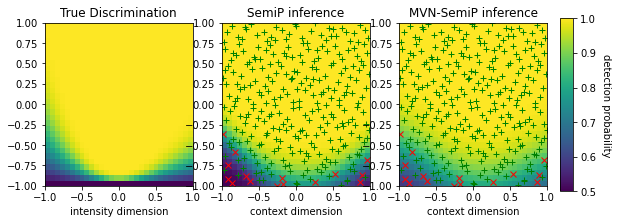

In [7]:
lb = [-1, -1] ##
ub = [1, 1]

xgrid = dim_grid(lower=lb, upper=ub, dim=2, gridsize = 30)

fgrid = novel_discrimination_testfun(xgrid)


# now generate some data from the Bernoulli distribution defined over a set of training locations
xtrain = make_scaled_sobol(lb=lb, ub=ub, size=300) # using random sobol sampling here for data generation
ftrain = novel_discrimination_testfun(xtrain)
ytrain = Bernoulli(torch.Tensor(norm.cdf(ftrain))).sample()

### fit SemiP model

## note you can adjust the slope_mean value to bias a steeper rise with intensity.
# Default value is 2, here we are setting to 6
semip_model = SemiParametricGPModel(lb=lb, ub=ub, dim=2, stim_dim=1, slope_mean=6,
                                    likelihood=LinearBernoulliLikelihood(objective=FloorProbitObjective(floor=0.5)))
semip_model.fit(xtrain, ytrain)

approx_model = HadamardSemiPModel(lb=lb, ub=ub, dim=2, stim_dim=1, slope_mean=6,
                                  likelihood=BernoulliObjectiveLikelihood(objective=FloorProbitObjective(floor=0.5)))

semip_model.fit(xtrain, ytrain)
approx_model.fit(xtrain, ytrain)

#make predictions at locations on a 2D grid and plot
semiP_pred_mu, _ = semip_model.predict(torch.Tensor(xgrid), probability_space=True)
approx_pred_mu, _ = approx_model.predict(torch.Tensor(xgrid), probability_space=True)

fig, axs = plt.subplots(1, 3, figsize=(9, 3))

axs[0].imshow(norm.cdf(fgrid).reshape(30, 30).T, aspect="auto", origin="lower", vmin=0.5, vmax=1,
              extent=[lb[0], ub[0], lb[1], ub[1]])
axs[0].set_title('True Discrimination')
axs[0].set_xlabel("context dimension")
axs[0].set_xlabel("intensity dimension")

im1 = axs[1].imshow(semiP_pred_mu.reshape(30, 30).T, aspect="auto", origin="lower", vmin=0.5, vmax=1,
                    extent=[lb[0], ub[0], lb[1], ub[1]])
axs[1].set_title('SemiP inference')
axs[1].set_xlabel("context dimension")
axs[1].plot(xtrain[ytrain==0,0], xtrain[ytrain==0,1], 'rx')
axs[1].plot(xtrain[ytrain==1,0], xtrain[ytrain==1,1], 'g+')

axs[2].imshow(approx_pred_mu.reshape(30, 30).T, aspect="auto", origin="lower", vmin=0.5, vmax=1,
              extent=[lb[0], ub[0], lb[1], ub[1]])
axs[2].set_title('MVN-SemiP inference')
axs[2].set_xlabel("context dimension")
axs[2].plot(xtrain[ytrain==0,0], xtrain[ytrain==0,1], 'rx')
axs[2].plot(xtrain[ytrain==1,0], xtrain[ytrain==1,1], 'g+')

cb_ax = fig.add_axes([.92, 0.1, 0.02, 0.8])
cbar = fig.colorbar(im1, cax=cb_ax)
cbar.set_label("detection probability", rotation=270, labelpad=15)

# Active learning

Finally, we provide an example active learning experiment using the semi-parametric models. For more on how active learning in AEPsych works, see the [introductory documentation](https://aepsych.org/docs/gp_intro)
